In [26]:
from plot_utils import create_heat_map
from feats_utils import extract_features_from_data, get_corr_for_categorical
from logger import Logger

import pandas as pd
import numpy as np
import os

%matplotlib inline

In [27]:
logger = Logger(show = True, html_output = True, config_file = "config.txt")

logger.log("Reading transactions file...")
df = pd.read_csv(logger.get_data_file(logger.config_dict['DATA_FILE']))
logger.log("Finish reading {} rows".format(df.shape[0]), show_time = True)
print(os.linesep + "Data snippet")
df.head()

2019.05.09-16:23:34 Initialize the logger
2019.05.09-16:23:34 Create logs folder logs
2019.05.09-16:23:34 Create log file logs\2019-05-09_16_23_34_log0.html
2019.05.09-16:23:34 Create models folder models
2019.05.09-16:23:34 Create output folder output
2019.05.09-16:23:34 Create data folder data
2019.05.09-16:23:34 Read config file config.txt
[2019.05.09-16:23:34] Reading transactions file...
[2019.05.09-16:23:37] Finish reading 290382 rows [3.01s]

Data snippet


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [29]:
crt_size = df.shape[0]

df['mail_id'] = df['mail_id'].str.replace('email','')
df.drop(df[df.mail_id == "NA"].index, inplace=True)
df['mail_id'] = pd.to_numeric(df['mail_id'])
logger.log("Dropping NA in email id {}".format(crt_size - df.shape[0]))
crt_size = df.shape[0]

df['ip_id']   = df['ip_id'].str.replace('ip','')
df.drop(df[df.ip_id == "NA"].index, inplace=True)
df['ip_id'] = pd.to_numeric(df['ip_id'])
logger.log("Dropping NA in ip id {}".format(crt_size - df.shape[0]))
crt_size = df.shape[0]

df['card_id'] = df['card_id'].str.replace('card','')
df.drop(df[df.card_id == "NA"].index, inplace=True)
df['card_id'] = pd.to_numeric(df['card_id'])
logger.log("Dropping NA in card id {}".format(crt_size - df.shape[0]))
crt_size = df.shape[0]

(df[df['mail_id'].isna()].simple_journal == "Chargeback").sum()

[2019.05.09-16:24:11] Dropping NA in email id 366
[2019.05.09-16:24:12] Dropping NA in ip id 0
[2019.05.09-16:24:13] Dropping NA in card id 0


0

In [4]:
df.drop(df[df.simple_journal == "Refused"].index, inplace=True)
logger.log("Dropping REFUSED transaction {}".format(crt_size - df.shape[0]))
crt_size = df.shape[0] 

[2019.05.09-13:15:30] Dropping REFUSED transaction 53318


In [5]:
logger.log("Number of NaNs per column:" + os.linesep + "{}".format(df.isna().sum()))

[2019.05.09-13:15:30] Number of NaNs per column:
txid                                0
bookingdate                         0
issuercountrycode                   4
txvariantcode                       0
bin                                 0
amount                              0
currencycode                        0
shoppercountrycode                342
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    13194
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64


In [6]:
print(os.linesep + "Few examples of NaNs rows:")
df[df.isna().any(axis=1)].head()


Few examples of NaNs rows:


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
25297,39506,2015-09-27 20:21:39,MX,mccredit,528843.0,61530.0,MXN,NaN,Ecommerce,Settled,True,0,2015-09-27 20:21:27,MexicoAccount,263004.0,86356.0,39750.0
25592,40058,2015-09-30 06:32:50,NaN,mc,520116.0,119940.0,MXN,MX,Ecommerce,Settled,True,0,2015-09-30 06:32:40,MexicoAccount,47407.0,61517.0,46742.0
27227,43731,2015-10-19 20:40:32,NaN,mc,520116.0,44800.0,MXN,MX,Ecommerce,Settled,True,0,2015-10-19 20:40:16,MexicoAccount,47407.0,61517.0,46742.0
27307,43927,2015-10-20 20:30:51,NaN,mc,520116.0,111920.0,MXN,MX,Ecommerce,Settled,True,0,2015-10-20 20:30:43,MexicoAccount,164167.0,76472.0,269591.0
31536,50220,2015-07-02 04:35:15,AU,mccredit,535316.0,11000.0,AUD,AU,Ecommerce,Settled,NaN,0,2015-07-01 03:45:57,APACAccount,267790.0,17828.0,194191.0


In [7]:
logger.log("NaNs from issuercountrycode that are Chargeback: {}".format(
    (df[df['issuercountrycode'].isna()].simple_journal == "Chargeback").sum()))
logger.log("NaNs from shoppercountrycode that are Chargeback: {}".format(
    (df[df['shoppercountrycode'].isna()].simple_journal == "Chargeback").sum()))
logger.log("NaNs from cardverificationcodesupplied that are Chargeback: {}".format(
    (df[df['cardverificationcodesupplied'].isna()].simple_journal == "Chargeback").sum()))

[2019.05.09-13:15:30] NaNs from issuercountrycode that are Chargeback: 0
[2019.05.09-13:15:30] NaNs from shoppercountrycode that are Chargeback: 0
[2019.05.09-13:15:30] NaNs from cardverificationcodesupplied that are Chargeback: 0


In [8]:
df.dropna(axis = 0, inplace = True)
logger.log("Drop the other NaNs: {} entries".format(crt_size - df.shape[0]))
crt_size = df.shape[0]

[2019.05.09-13:15:30] Drop the other NaNs: 13526 entries


In [9]:
logger.log("Convert datatypes for numeric and timestamps")

df['bookingdate']  = pd.to_datetime(df['bookingdate'])
df['creationdate'] = pd.to_datetime(df['creationdate'])
df = df.infer_objects()

df['bin'] = df['bin'].astype(object)
df['mail_id'] = df['mail_id'].astype(object)
df['card_id'] = df['card_id'].astype(object)
df['ip_id'] = df['ip_id'].astype(object)

print(os.linesep + "{}".format(df.dtypes))

[2019.05.09-13:15:30] Convert datatypes for numeric and timestamps

txid                                     int64
bookingdate                     datetime64[ns]
issuercountrycode                       object
txvariantcode                           object
bin                                     object
amount                                 float64
currencycode                            object
shoppercountrycode                      object
shopperinteraction                      object
simple_journal                          object
cardverificationcodesupplied              bool
cvcresponsecode                          int64
creationdate                    datetime64[ns]
accountcode                             object
mail_id                                 object
ip_id                                   object
card_id                                 object
dtype: object


In [10]:
logger.log("Sort after creationdate")
df.sort_values('creationdate', inplace = True)
df.reset_index(drop = True, inplace = True)

[2019.05.09-13:15:31] Sort after creationdate


In [11]:
import math
logger.log("Currencies identified in data are {}".format(np.unique(df.currencycode.values)))

conversion = {'AUD': 0.699165, 'GBP': 1.31061, 'MXN': 0.222776586, 'NZD': 0.66152, 'SEK': 0.104405}
logger.log("Convert all amounts in USD using rates: {}".format(conversion))
df['amount'] = df.apply(lambda e: int(math.floor(e['amount'] * conversion[e['currencycode']])) , axis=1)
logger.log("Done converting", show_time = True)

[2019.05.09-13:15:31] Currencies identified in data are ['AUD' 'GBP' 'MXN' 'NZD' 'SEK']
[2019.05.09-13:15:31] Convert all amounts in USD using rates: {'AUD': 0.699165, 'GBP': 1.31061, 'MXN': 0.222776586, 'NZD': 0.66152, 'SEK': 0.104405}
[2019.05.09-13:15:36] Done converting [4.88s]


In [12]:
logger.log("Drop txid and bookingdate")
df.drop(["txid", "bookingdate"], inplace = True, axis = 1)

logger.log("Change simple_journal to label")
df.replace({'simple_journal': {"Settled": 0, "Chargeback": 1}}, inplace = True)
df.rename(columns = {'simple_journal': 'label'}, inplace = True)

logger.log("Rearrange columns")
columns = ["creationdate", "card_id", "mail_id", "ip_id", "issuercountrycode", "txvariantcode", 
           "bin", "shoppercountrycode", "shopperinteraction", "cardverificationcodesupplied", 
           "cvcresponsecode", "accountcode", "amount", "currencycode", "label"]
df = df[columns]

[2019.05.09-13:15:36] Drop txid and bookingdate
[2019.05.09-13:15:36] Change simple_journal to label
[2019.05.09-13:15:36] Rearrange columns


In [13]:
logger.log("Start extracting additional features")
additional_feats_df = extract_features_from_data(df)
logger.log("Finished extracting additional features", show_time = True)
numeric_columns = additional_feats_df.columns.to_list()

[2019.05.09-13:15:36] Start extracting additional features
[2019.05.09-13:16:25] Finished extracting additional features [49.20s]


In [14]:
full_df = pd.concat([df, additional_feats_df], axis = 1)

full_df_non_fraud = full_df[full_df.label == 0]
full_df_fraud = full_df[full_df.label == 1]

full_df_fraud.iloc[:, -10:].describe()
full_df_non_fraud.iloc[:, -10:].describe()

,label,Txn_Amount_Month,Average_3Months,Average_DailyMonth,Amount_SameDay,Number_Same_Day,Amount_Currency_Type_Month,Number_Currency_Type_Month,Amount_Country_Type_Month,Number_Country_Type_Month
count,222827.0,222827.000000,222827.000000,222827.000000,222827.000000,222827.000000,222827.000000,222827.000000,222827.000000,222827.000000
mean,0.0,921.929208,222.301955,59.320761,302.037743,0.030059,1778.467850,0.189308,1688.290165,0.170262
std,0.0,5318.256630,1714.450536,541.036220,4967.228591,0.437707,16229.465491,2.174842,15220.169817,1.801616
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,318995.920950,79070.739563,29820.964635,440364.960000,25.000000,894628.939050,99.000000,831372.347400,92.000000


In [15]:
print(os.linesep + "Snippet of data after preprocessing")
full_df.iloc[123412:123417, :]


Snippet of data after preprocessing


,creationdate,card_id,mail_id,ip_id,issuercountrycode,txvariantcode,bin,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,...,label,Txn_Amount_Month,Average_3Months,Average_DailyMonth,Amount_SameDay,Number_Same_Day,Amount_Currency_Type_Month,Number_Currency_Type_Month,Amount_Country_Type_Month,Number_Country_Type_Month
123412,2015-09-04 13:15:16,129055,112364,234838,GB,visadebit,475116,GB,Ecommerce,True,...,0,0.000000,0.000000,0.000000,0.0,0,0.00000,0,0.00000,0
123413,2015-09-04 13:15:17,128053,335613,157557,AU,visaclassic,450949,AU,Ecommerce,True,...,0,0.000000,0.000000,0.000000,0.0,0,0.00000,0,0.00000,0
123414,2015-09-04 13:15:54,119212,307511,255562,GB,mccredit,540758,GB,Ecommerce,True,...,0,7716.216375,1286.036063,514.414425,0.0,0,15432.43275,2,15432.43275,2
123415,2015-09-04 13:16:07,81318,12338,232898,GB,mccredit,512687,GB,Ecommerce,True,...,0,0.000000,0.000000,0.000000,0.0,0,0.00000,0,0.00000,0
123416,2015-09-04 13:16:34,269983,159864,342982,SE,mcdebit,534243,SE,Ecommerce,True,...,0,0.000000,0.000000,0.000000,0.0,0,0.00000,0,0.00000,0


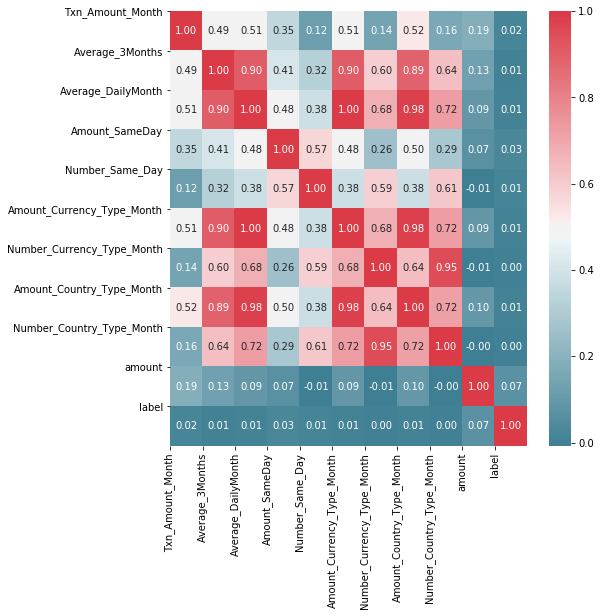

In [16]:
numeric_columns.append("amount")
numeric_df = full_df[numeric_columns + ["label"]]

numeric_corr = numeric_df.corr(method = 'pearson')
create_heat_map("HeatMap", numeric_corr, numeric_df.columns.to_list(), 
                "num_corr_heatmap.jpg", logger)

In [24]:
categorical_columns = list(set(full_df.columns.to_list()) - set(numeric_df.columns.to_list()))
categorical_columns.remove("creationdate")
categorical_columns.append("label")
categorical_df = full_df_fraud[categorical_columns]

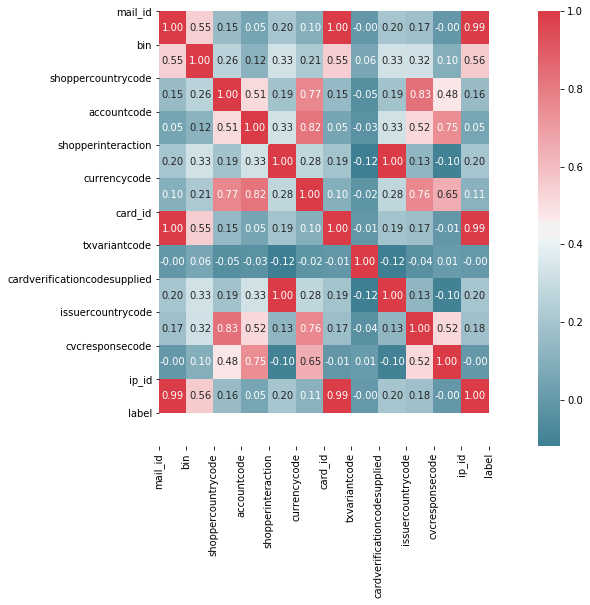

In [25]:
#categorical_corr = get_corr_for_categorical(categorical_df)
categorical_corr = categorical_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
create_heat_map("HeatMap", categorical_corr, categorical_df.columns.to_list(), 
                "cat_corr_heatmap.jpg", logger)

In [ ]:
slice = categorical_df[]